In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def HR(self, X):
    x, y, z = X
    return [y - x**3 + b*x**2 + I - z,
            1 - 5*x**2 - y,
            mu*(s*(x-x_test) - z)
            ]

In [3]:
s = 4
mu = 0.01
x_test = -1.6

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
trainx3 = np.load('HRData/Area3.npy')[0][:15000]
trainx5 = np.load('HRData/Area5.npy')[0][:15000]
trainx6 = np.load('HRData/Area6.npy')[0][:15000]
trainx7 = np.load('HRData/Area7.npy')[0][:15000]
traingr1 = np.load('HRData/Area11.npy')[0][:15000]
traingr2 = np.load('HRData/Area12.npy')[0][:15000]
traingr3 = np.load('HRData/Area13.npy')[0][:15000]
traingr4 = np.load('HRData/Area14.npy')[0][:15000]
traingr5 = np.load('HRData/Area15.npy')[0][:15000]
traingr6 = np.load('HRData/Area16.npy')[0][:15000]

testx3 = np.load('HRData/Area3.npy')[0][15000:]
testx5 = np.load('HRData/Area5.npy')[0][15000:]
testx6 = np.load('HRData/Area6.npy')[0][15000:]
testx7 = np.load('HRData/Area7.npy')[0][15000:]
testgr1 = np.load('HRData/Area11.npy')[0][15000:]
testgr2 = np.load('HRData/Area12.npy')[0][15000:]
testgr3 = np.load('HRData/Area13.npy')[0][15000:]
testgr4 = np.load('HRData/Area14.npy')[0][15000:]
testgr5 = np.load('HRData/Area15.npy')[0][15000:]
testgr6 = np.load('HRData/Area16.npy')[0][15000:]

In [6]:
trainy3 = np.load('HRData/Area3.npy')[1][:15000]
trainy5 = np.load('HRData/Area5.npy')[1][:15000]
trainy6 = np.load('HRData/Area6.npy')[1][:15000]
trainy7 = np.load('HRData/Area7.npy')[1][:15000]
traingry1 = np.load('HRData/Area11.npy')[1][:15000]
traingry2 = np.load('HRData/Area12.npy')[1][:15000]
traingry3 = np.load('HRData/Area13.npy')[1][:15000]
traingry4 = np.load('HRData/Area14.npy')[1][:15000]
traingry5 = np.load('HRData/Area15.npy')[1][:15000]
traingry6 = np.load('HRData/Area16.npy')[1][:15000]

testy3 = np.load('HRData/Area3.npy')[1][15000:]
testy5 = np.load('HRData/Area5.npy')[1][15000:]
testy6 = np.load('HRData/Area6.npy')[1][15000:]
testy7 = np.load('HRData/Area7.npy')[1][15000:]
testgry1 = np.load('HRData/Area11.npy')[1][15000:]
testgry2 = np.load('HRData/Area12.npy')[1][15000:]
testgry3 = np.load('HRData/Area13.npy')[1][15000:]
testgry4 = np.load('HRData/Area14.npy')[1][15000:]
testgry5 = np.load('HRData/Area15.npy')[1][15000:]
testgry6 = np.load('HRData/Area16.npy')[1][15000:]

In [7]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [8]:
def MakeDatasets(train, test, mean=None, std=None):
    if mean is None:
        mean = np.array(train).mean()
    if std is None:
        std = np.array(train).std()
    
    for i in range(len(train)):
        train[i] = (train[i] - mean)/std
        train[i] = torch.FloatTensor(train[i]).view(-1)
        
        test[i] = (test[i] - mean)/std
        test[i] = torch.FloatTensor(test[i]).view(-1)
    
    train_inout_seq = create_inout_sequences(train[0], train_window)
    test_inout_seq = create_inout_sequences(test[0], train_window)
    for i in range(1, len(train)):
        train_inout_seq += create_inout_sequences(train[i], train_window)
        test_inout_seq += create_inout_sequences(test[i], train_window)
        
    return mean, std, train_inout_seq, test_inout_seq


In [9]:
meanx, stdx, train_inout_seq, test_inout_seq = MakeDatasets([trainx3, trainx5, trainx6, trainx7, traingr1, traingr2, traingr3, traingr4, traingr5, traingr6], 
                                               [testx3, testx5, testx6, testx7, testgr1, testgr2, testgr3, testgr4, testgr5, testgr6])

In [10]:
meany, stdy, train_inout_seq_y, test_inout_seq_y = MakeDatasets([trainy3, trainy5, trainy6, trainy7, traingry1, traingry2, traingry3, traingry4, traingry5, traingry6], 
                                               [testy3, testy5, testy6, testy7, testgry1, testgry2, testgry3, testgry4, testgry5, testgry6])

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Floating
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [17]:
from torch.utils.data import DataLoader

In [18]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=True, drop_last=True)

In [19]:
train_dataloader_y = DataLoader(train_inout_seq_y, batch_size=64, shuffle=True, drop_last=True)
test_dataloader_y = DataLoader(test_inout_seq_y, batch_size=64, shuffle=True, drop_last=True)

In [20]:
model = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model = model.to('cuda')

In [21]:
from IPython.display import clear_output

In [22]:
def run_epoch(model, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

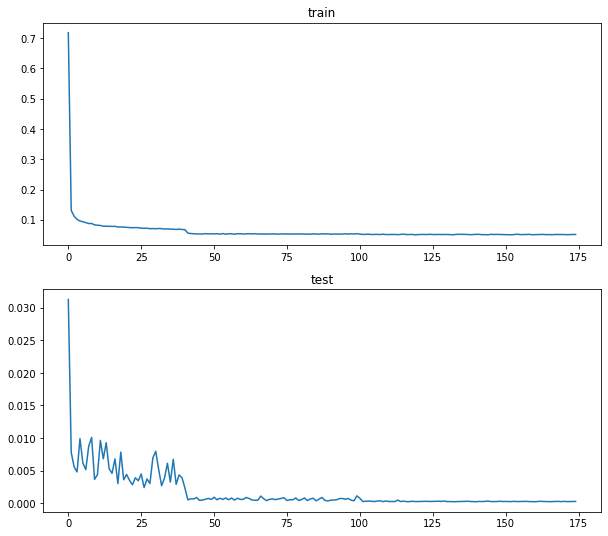

Epoch[175/175] | loss train:0.051421, test:0.000256


In [15]:
# define optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
lr = 0.001

losses_train = []
losses_test = []
# begin training
for epoch in range(175): 
    if epoch > 40:
        lr = 0.0001
    if epoch > 100:
        lr = 0.00001
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)    
    loss_train = run_epoch(model, train_dataloader, is_training=True)
    loss_val = run_epoch(model, test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 175, loss_train, loss_val))

In [16]:
torch.save(model.state_dict(), 'HRxModel')

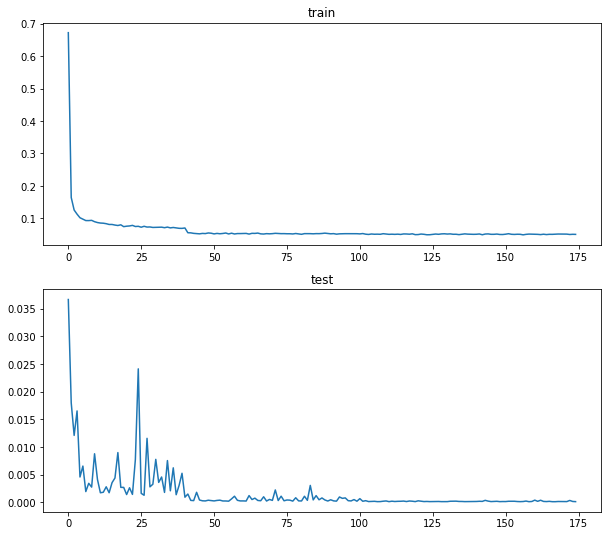

Epoch[175/175] | loss train:0.050607, test:0.000120


In [16]:

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
lr = 0.001

losses_train = []
losses_test = []
# begin training
for epoch in range(175): 
    if epoch > 40:
        lr = 0.0001
    if epoch > 100:
        lr = 0.00001
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)    
    loss_train = run_epoch(model, train_dataloader_y, is_training=True)
    loss_val = run_epoch(model, test_dataloader_y)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 175, loss_train, loss_val))

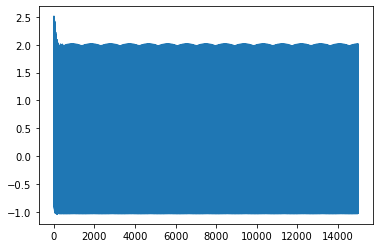

In [ ]:
plt.plot(trainx3)

In [23]:
def ShowPredict(model, train, test, mean=None, std=None):
    if mean is None:
        mean = train.mean()
    if std is None:
        std = train.std()
    train = (train - mean)/std
    train = torch.FloatTensor(train).view(-1)
        
    test = (test - mean)/std
    test = torch.FloatTensor(test).view(-1)
    
    train_inout_seq = create_inout_sequences(train, train_window)
    test_inout_seq = create_inout_sequences(test, train_window)
    train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=False, drop_last=True)
    val_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

    model.eval()

    # predict on the training data, to see how well the model managed to learn and memorize

    predicted_train = np.array([])

    for idx, (x, y) in enumerate(train_dataloader):
        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_train = np.concatenate((predicted_train, out))

    # predict on the test data

    predicted_val = np.array([])

    for idx, (x, y) in enumerate(val_dataloader):
        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_val = np.concatenate((predicted_val, out))
        
    fig = plt.figure(figsize=(16, 12))
        
    ax_1 = fig.add_subplot(3, 2, 1)
    ax_1.set_title("Bit of predicted train with true train")  
    ax_1.plot(train[220:340], label='true')
    ax_1.plot(predicted_train[200:320], label='predicted')
    ax_1.legend()
    
    ax_2 = fig.add_subplot(3, 2, 2)
    ax_2.set_title("Bit of predicted test with true test") 
    ax_2.plot(test[220:340], label='true')
    ax_2.plot(predicted_val[200:320], label='predicted')
    ax_2.legend()

    ax_3 = fig.add_subplot(3, 2, 3)
    ax_3.set_title("Predicted train") 
    ax_3.plot(predicted_train)

    ax_4 = fig.add_subplot(3, 2, 4)
    ax_4.set_title("Predicted test") 
    ax_4.plot(predicted_val)
    
    ax_5 = fig.add_subplot(3, 2, 6)
    ax_5.set_title("Test") 
    ax_5.plot(test)
    
    ax_6 = fig.add_subplot(3, 2, 5)
    ax_6.set_title("Train") 
    ax_6.plot(train)
    
    train_right_part = (len(train)- 20)%64
    test_right_part = (len(test)- 20)%64

    train_rmse = ((np.array(predicted_train) - np.array(train[20:-train_right_part]))**2).mean()**0.5
    test_rmse = ((np.array(predicted_val) - np.array(test[20:-test_right_part]))**2).mean()**0.5

    print("Train rmse:", train_rmse)
    print("Test rmse:", test_rmse)
    
    plt.show()

Train rmse: 0.0025656150483613824
Test rmse: 0.0018338047518489302


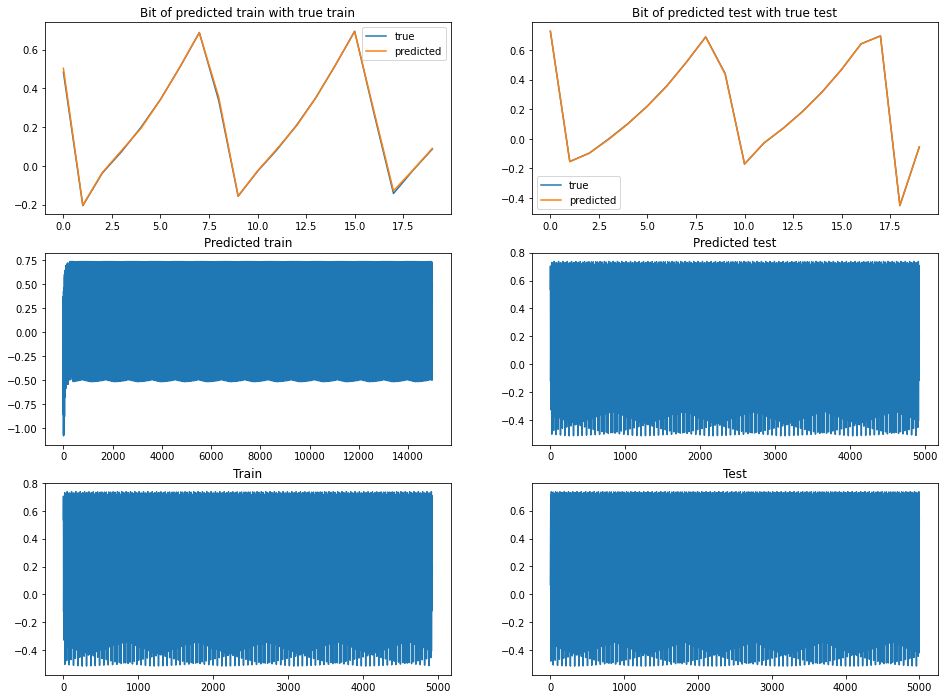

In [82]:
ShowPredict(model, trainy3, testy3, mean=meany, std = stdy)

Train rmse: 0.0029471897576155382
Test rmse: 0.00269081025887972


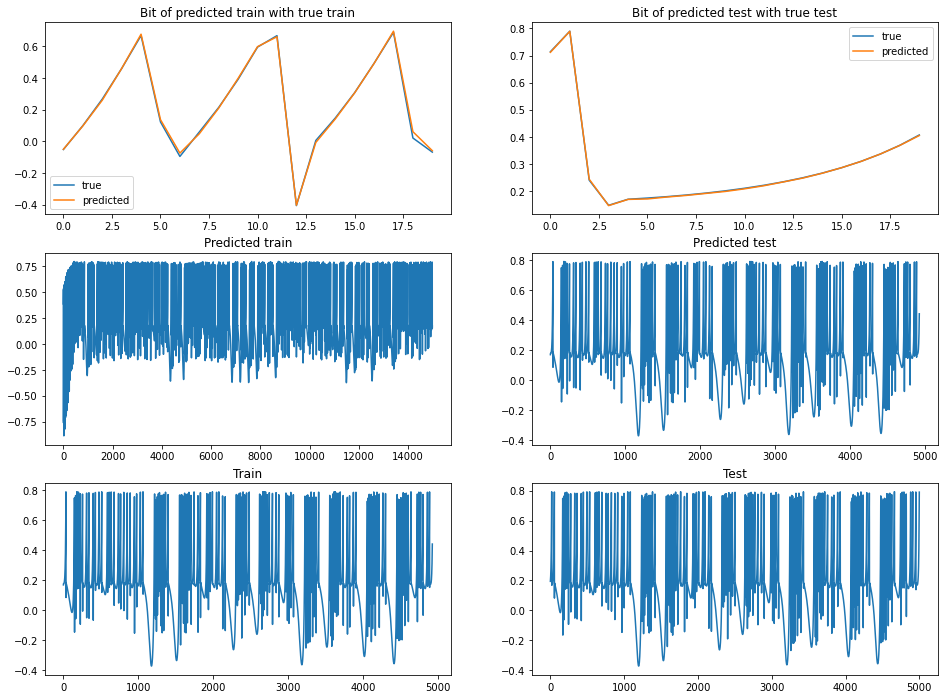

In [83]:
ShowPredict(model, traingry1, testgry1, mean=meany, std = stdy)

# Попробуем предсказать на новых данных

In [59]:
b = 3.05
I = 2.775
sol1_test = solve_ivp(HR, [0, 20000], [-0.1, 0.1, -0.1], 
                t_eval=np.array(range(5000, 10000, 1)), rtol = 1e-11, atol = 1e-11, dense_output=True)

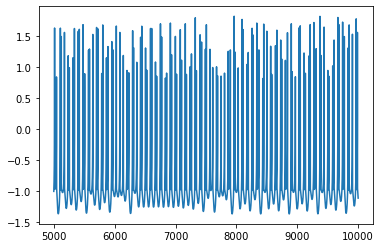

In [60]:
plt.plot(sol1_test.t, sol1_test.y[0])

In [61]:
np.save('AreaTest1', sol1_test.y)

In [62]:
b = 3.025
I = 3.225
sol2_test = solve_ivp(HR, [0, 20000], [-0.1, 0.1, -0.1], 
                t_eval=np.array(range(5000, 10000, 1)), rtol = 1e-11, atol = 1e-11, dense_output=True)

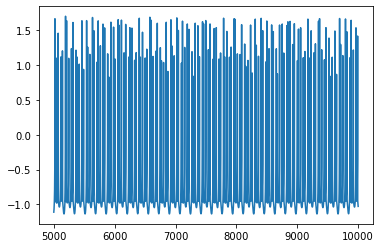

In [63]:
plt.plot(sol2_test.t, sol2_test.y[0])

In [64]:
np.save('AreaTest2', sol2_test.y)

In [27]:
test_new1 = np.load('HRData/AreaTest1.npy')[0]
test_new2 = np.load('HRData/AreaTest2.npy')[0]

Train rmse: 0.016522211322292858
Test rmse: 0.016522211322292858


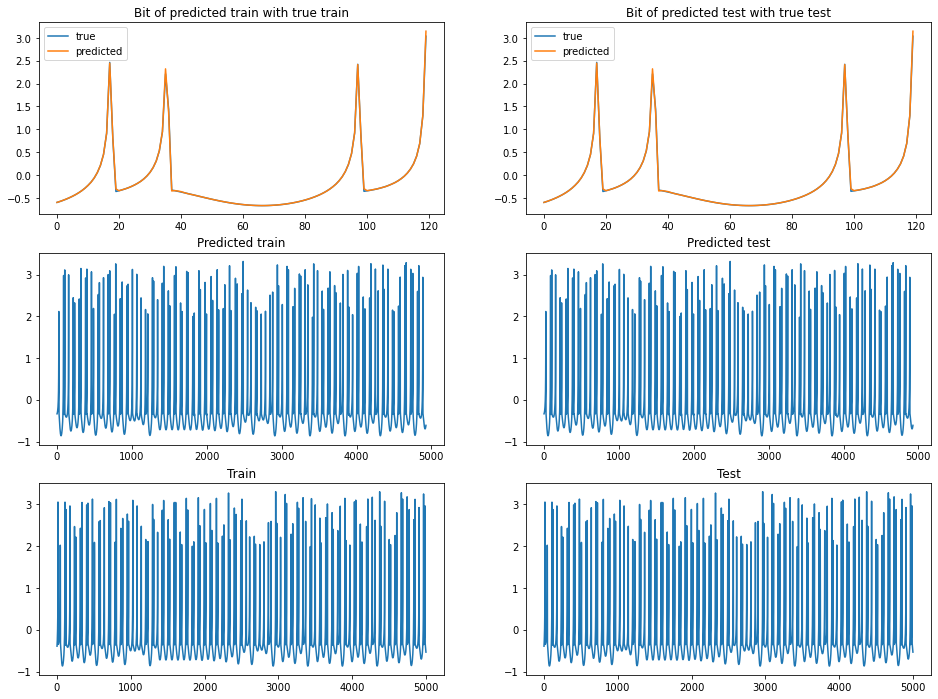

In [29]:
ShowPredict(model2, test_new1, test_new1, meanx, stdx)

Train rmse: 0.15224541147280754
Test rmse: 0.15224541147280754


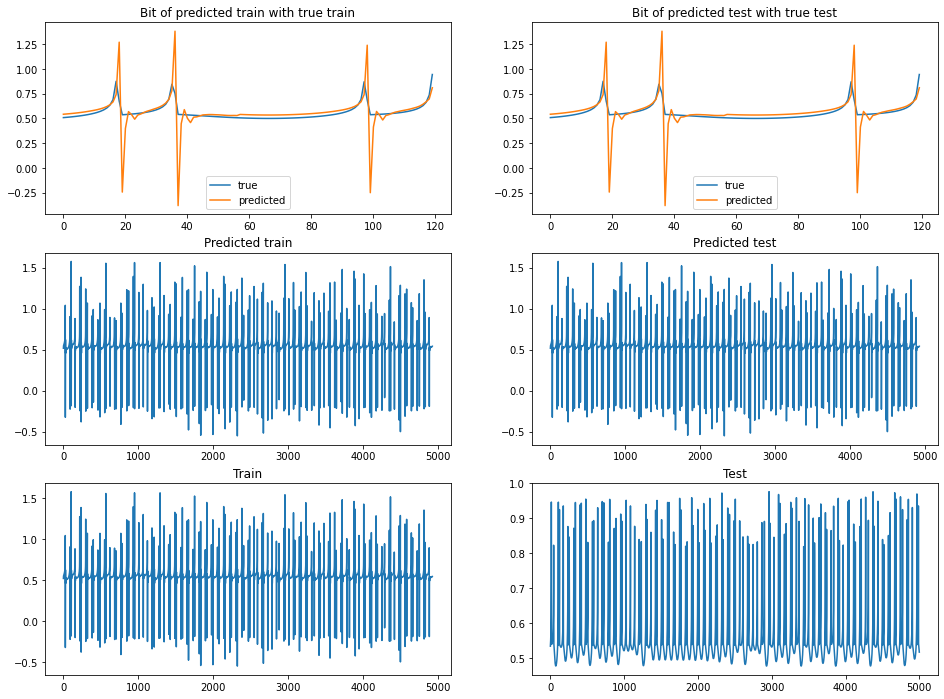

In [87]:
ShowPredict(model2, test_new1, test_new1)

Train rmse: 0.16803413330171366
Test rmse: 0.16803413330171366


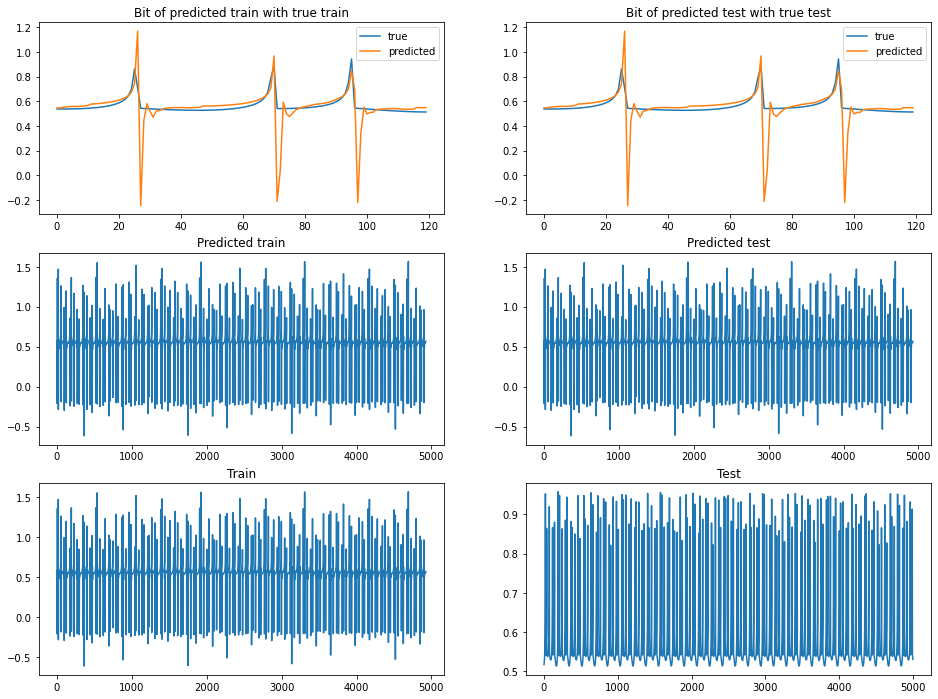

In [88]:
ShowPredict(model2, test_new2, test_new2)

# Предсказание с дообучением

In [24]:
model2 = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model2 = model2.to('cuda')

In [25]:
model2.load_state_dict(torch.load('HRxModel'))

<All keys matched successfully>

In [30]:
for para in model2.parameters():
    para.requires_grad = False

model2.linear_2.weight.requires_grad = True
model2.linear_2.bias.requires_grad = True

for para in model2.parameters():print(para)


Parameter containing:
tensor([[-1.5529e-01],
        [-5.4953e-01],
        [ 7.2464e-01],
        [ 1.3441e-01],
        [-2.8118e-03],
        [ 9.1170e-01],
        [-3.4329e-01],
        [ 5.8454e-03],
        [-1.9561e-01],
        [ 2.5326e-01],
        [ 6.5203e-01],
        [-2.8928e-01],
        [-4.6644e-03],
        [-4.1680e-01],
        [ 5.6196e-01],
        [-1.1106e-01],
        [-9.8150e-03],
        [-1.6213e-01],
        [-6.4660e-01],
        [-7.9330e-03],
        [-3.9736e-01],
        [-1.1675e-01],
        [-7.7144e-01],
        [-5.0351e-01],
        [-2.0262e-01],
        [-4.6796e-01],
        [-4.2442e-01],
        [-4.4931e-01],
        [-6.3681e-01],
        [-4.4688e-01],
        [ 8.0443e-01],
        [-6.5985e-02],
        [ 5.2759e-01],
        [-5.8798e-01],
        [ 2.3762e-01],
        [ 1.9070e-01],
        [ 5.9763e-01],
        [ 1.0385e-01],
        [ 7.6835e-03],
        [-2.7631e-01],
        [-8.4148e-01],
        [-7.5701e-02],
        [-7.

In [88]:
for para in model2.parameters():print(para)

Parameter containing:
tensor([[-1.5529e-01],
        [-5.4953e-01],
        [ 7.2464e-01],
        [ 1.3441e-01],
        [-2.8118e-03],
        [ 9.1170e-01],
        [-3.4329e-01],
        [ 5.8454e-03],
        [-1.9561e-01],
        [ 2.5326e-01],
        [ 6.5203e-01],
        [-2.8928e-01],
        [-4.6644e-03],
        [-4.1680e-01],
        [ 5.6196e-01],
        [-1.1106e-01],
        [-9.8150e-03],
        [-1.6213e-01],
        [-6.4660e-01],
        [-7.9330e-03],
        [-3.9736e-01],
        [-1.1675e-01],
        [-7.7144e-01],
        [-5.0351e-01],
        [-2.0262e-01],
        [-4.6796e-01],
        [-4.2442e-01],
        [-4.4931e-01],
        [-6.3681e-01],
        [-4.4688e-01],
        [ 8.0443e-01],
        [-6.5985e-02],
        [ 5.2759e-01],
        [-5.8798e-01],
        [ 2.3762e-01],
        [ 1.9070e-01],
        [ 5.9763e-01],
        [ 1.0385e-01],
        [ 7.6835e-03],
        [-2.7631e-01],
        [-8.4148e-01],
        [-7.5701e-02],
        [-7.

In [31]:
train_for_freez = test_new1[:1000]
test_for_freez = test_new1[1000:]


In [32]:
_, _, train_inout_seq_freeze, test_inout_seq_freeze = MakeDatasets([train_for_freez], [test_for_freez], meanx, stdx)

In [33]:
train_dataloader_freeze = DataLoader(train_inout_seq_freeze, batch_size=64, shuffle=True, drop_last=True)
test_dataloader_freeze = DataLoader(test_inout_seq_freeze, batch_size=64, shuffle=True, drop_last=True)

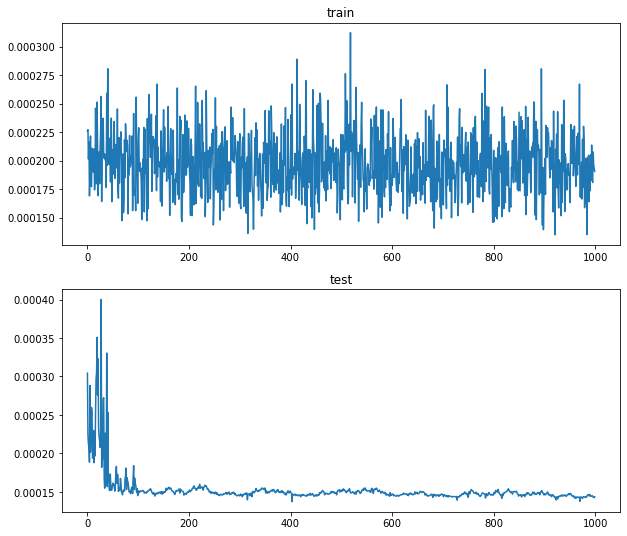

Epoch[1000/1000] | loss train:0.000191, test:0.000144


In [34]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
lr = 0.001

losses_train = []
losses_test = []

# begin training
for epoch in range(1000): 
    if epoch > 40:
        lr = 0.0001
    if epoch > 100:
        lr = 0.00001
    optimizer = optim.Adam(model2.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)    
    loss_train = run_epoch(model2, train_dataloader_freeze, is_training=True)
    loss_val = run_epoch(model2, test_dataloader_freeze)

    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 1000, loss_train, loss_val))

Train rmse: 0.013256429918911475
Test rmse: 0.012171749420724657


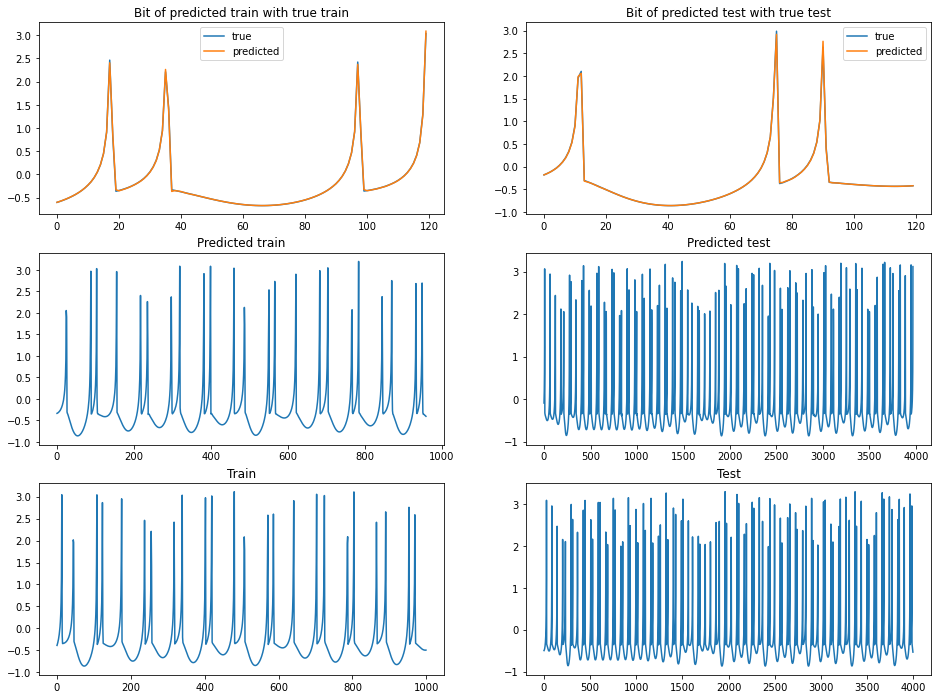

In [35]:
ShowPredict(model2, train_for_freez, test_for_freez, meanx, stdx)

Train rmse: 0.013393231633258137
Test rmse: 0.012286594639519808


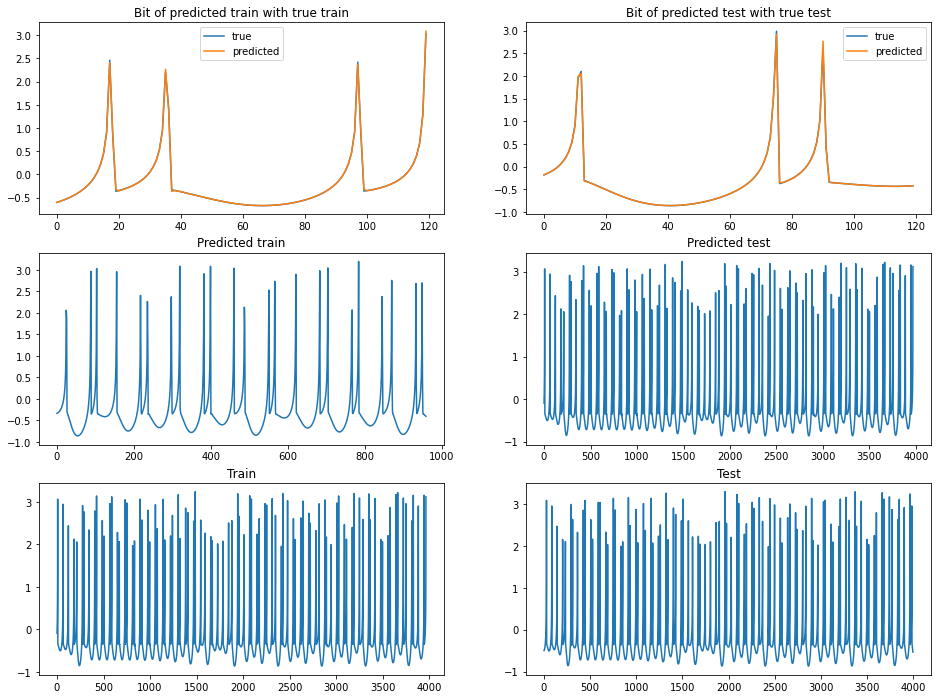

In [104]:
ShowPredict(model2, train_for_freez, test_for_freez, meanx, stdx)

Train rmse: 0.015550025402478117
Test rmse: 0.014025078110118957


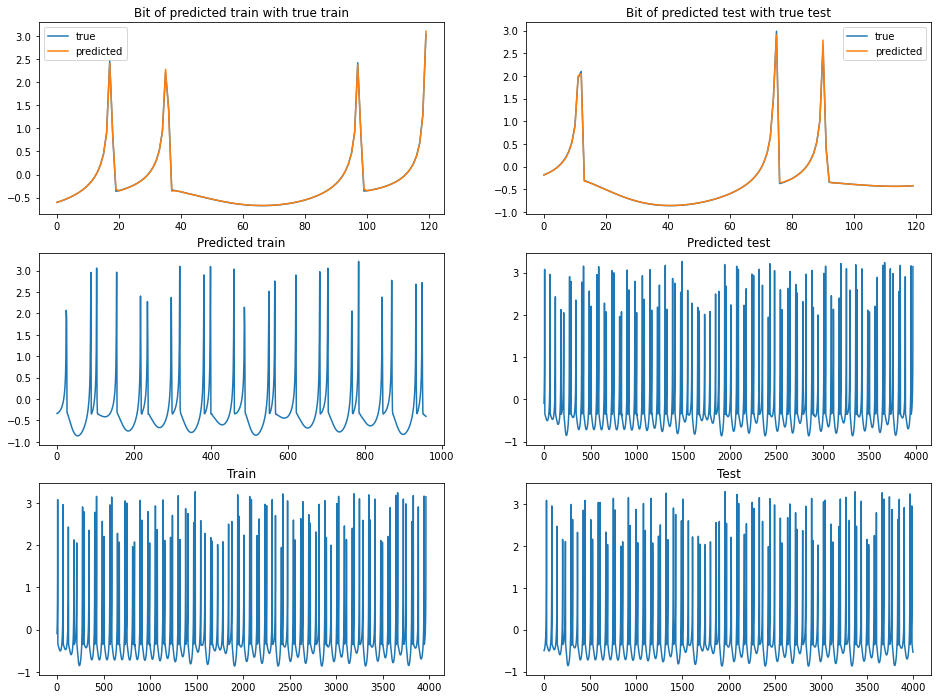

In [98]:
ShowPredict(model2, train_for_freez, test_for_freez, meanx, stdx)

Train rmse: 0.713674835458886
Test rmse: 0.7060194395125269


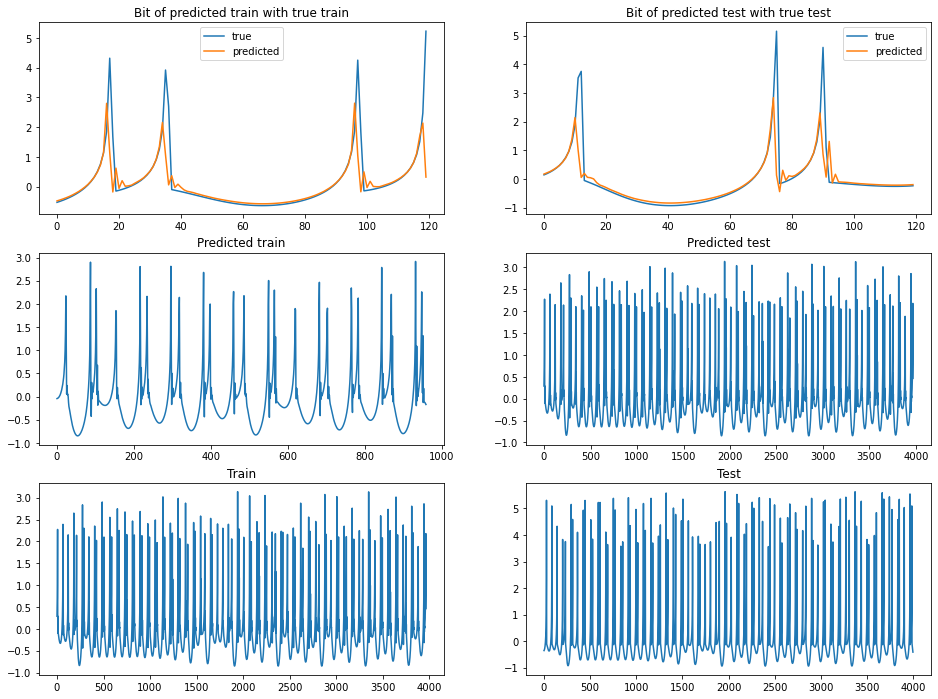

In [66]:
ShowPredict(model2, train_for_freez, test_for_freez)

In [67]:
model.load_state_dict(torch.load('HRxModel'))

<All keys matched successfully>

Train rmse: 0.01859693247339879
Test rmse: 0.016445745564070312


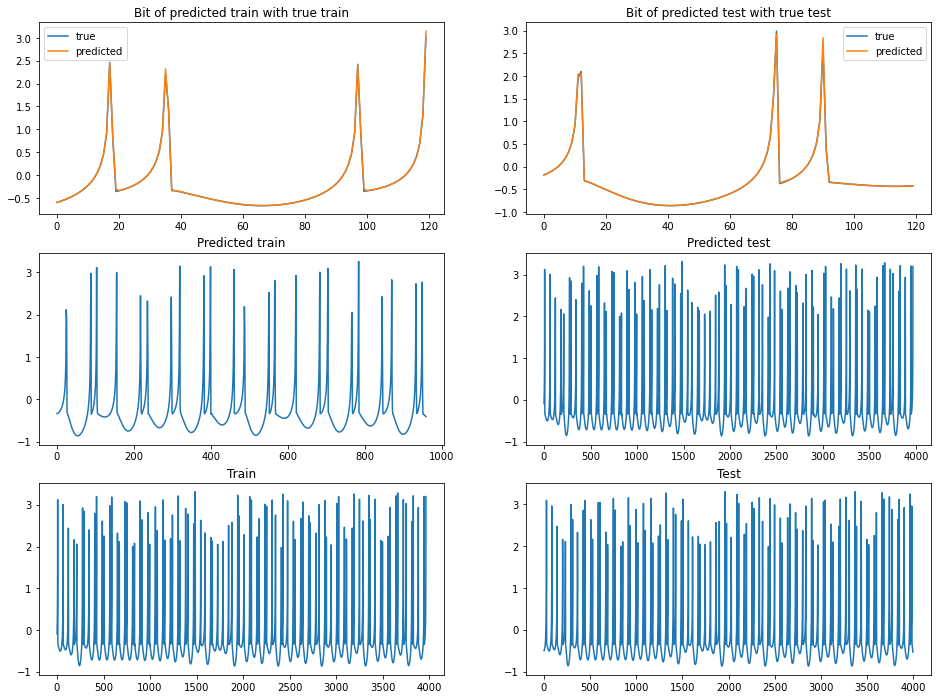

In [90]:
ShowPredict(model, train_for_freez, test_for_freez, meanx, stdx)

# Предсказание для x

Train rmse: 0.0046554198350477645
Test rmse: 0.004668503909245527


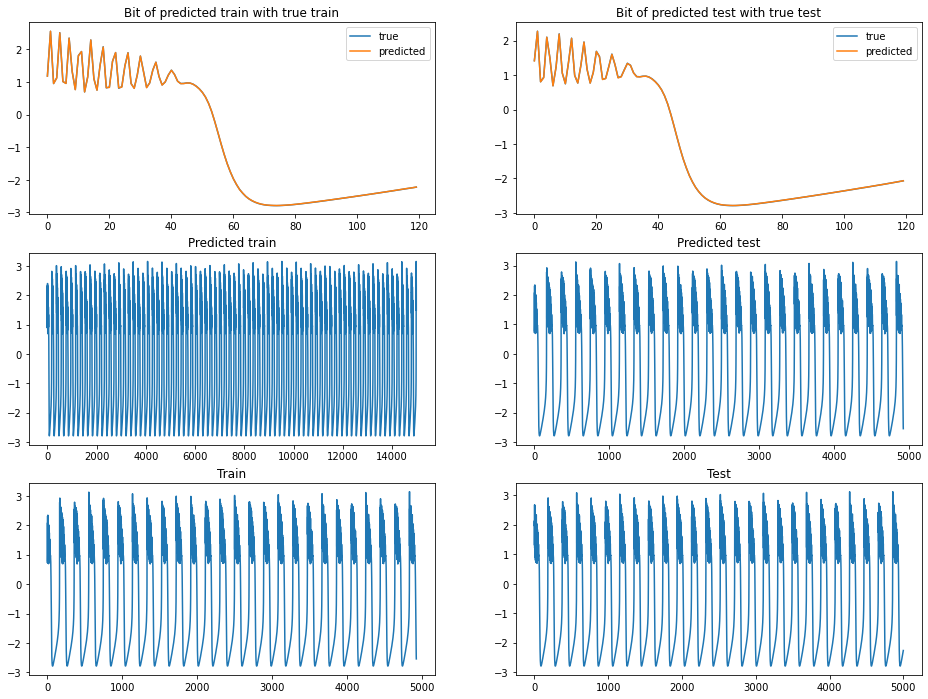

In [70]:
ShowPredict(model, trainx5, testx5, meanx, stdx)

Train rmse: 0.0032971719212654517
Test rmse: 0.0028267678854822747


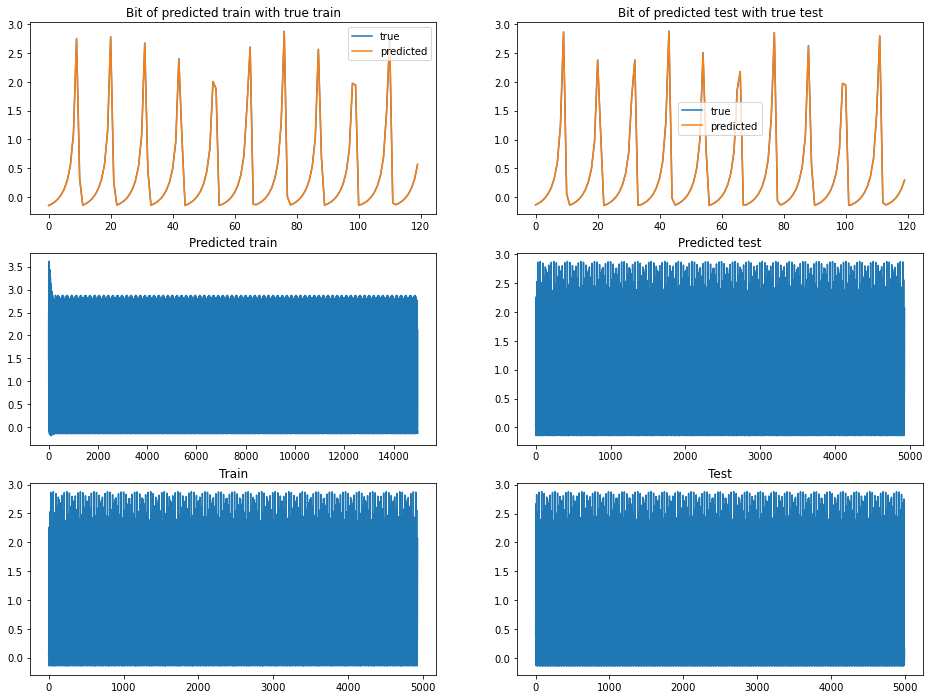

In [71]:
ShowPredict(model, trainx6, testx6, meanx, stdx)

Train rmse: 0.005532643644269434
Test rmse: 0.003423622567687728


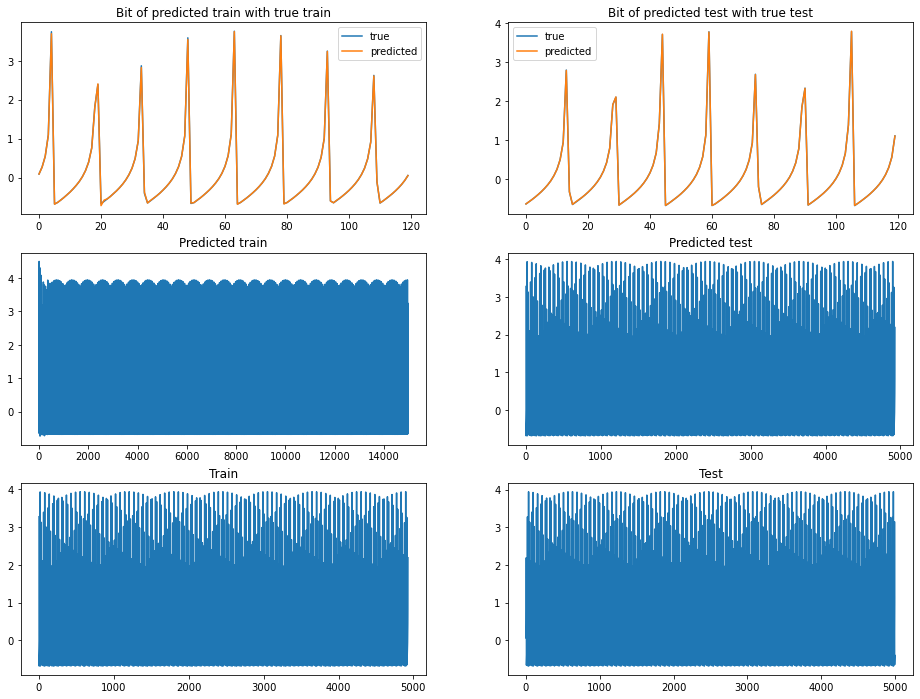

In [78]:
ShowPredict(model, trainx7, testx7, meanx, stdx)

Train rmse: 0.005582089131164775
Test rmse: 0.005418765684416818


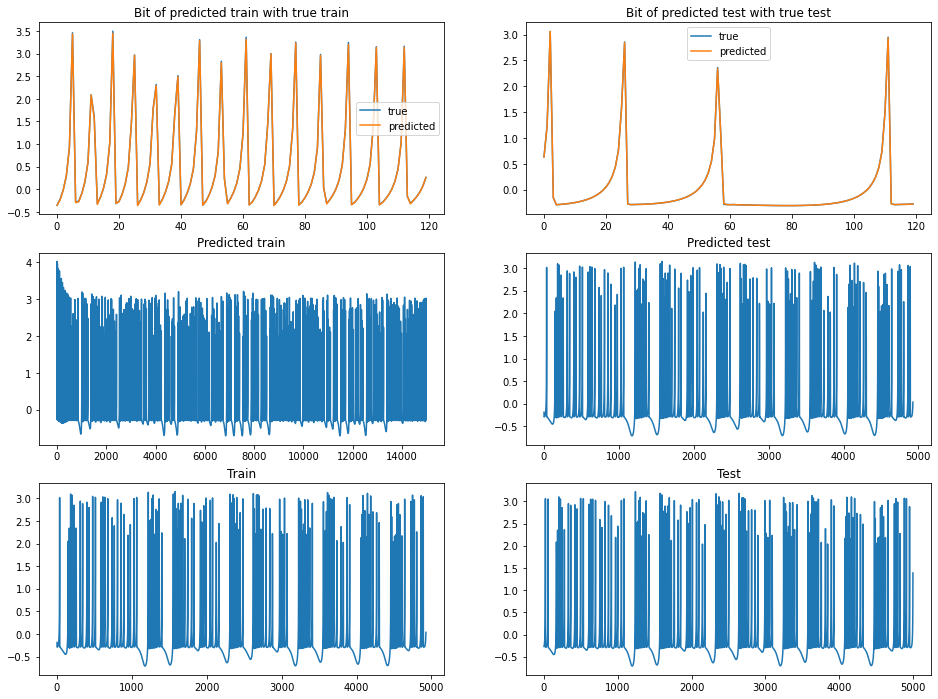

In [72]:
ShowPredict(model, traingr1, testgr1, meanx, stdx)

Train rmse: 0.0054334437357441015
Test rmse: 0.004889922434346672


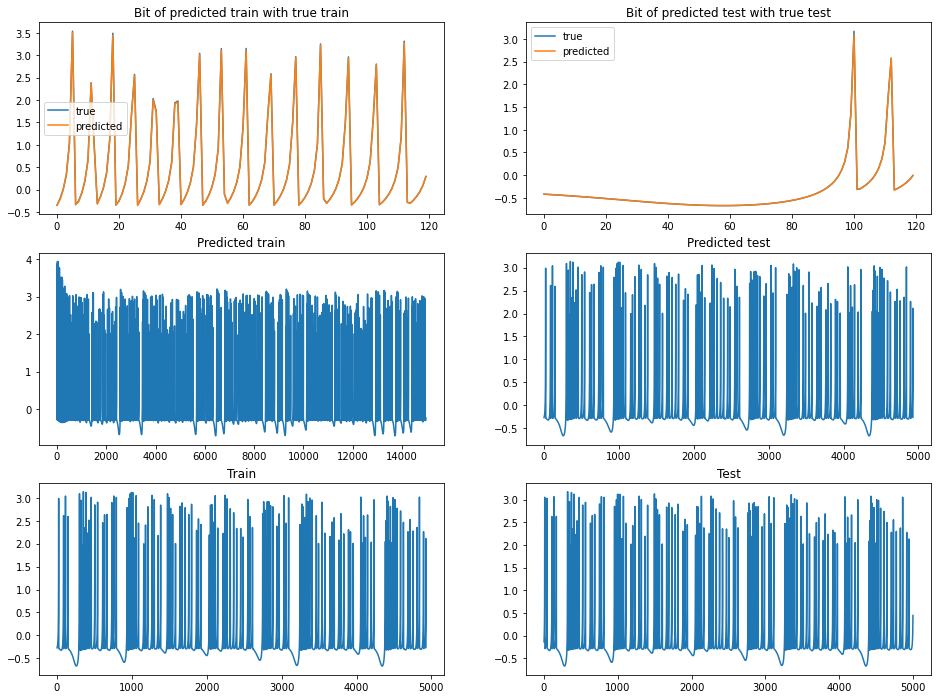

In [73]:
ShowPredict(model, traingr2, testgr2, meanx, stdx)

Train rmse: 0.0053827643583783625
Test rmse: 0.005491614239190793


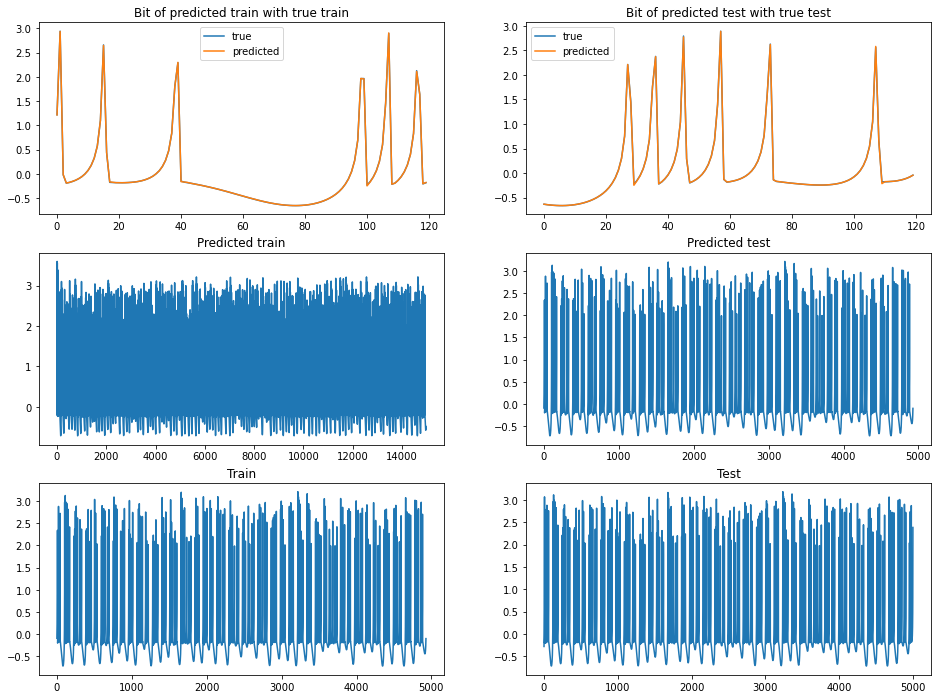

In [74]:
ShowPredict(model, traingr3, testgr3, meanx, stdx)

Train rmse: 0.004901677354315261
Test rmse: 0.005219958070641451


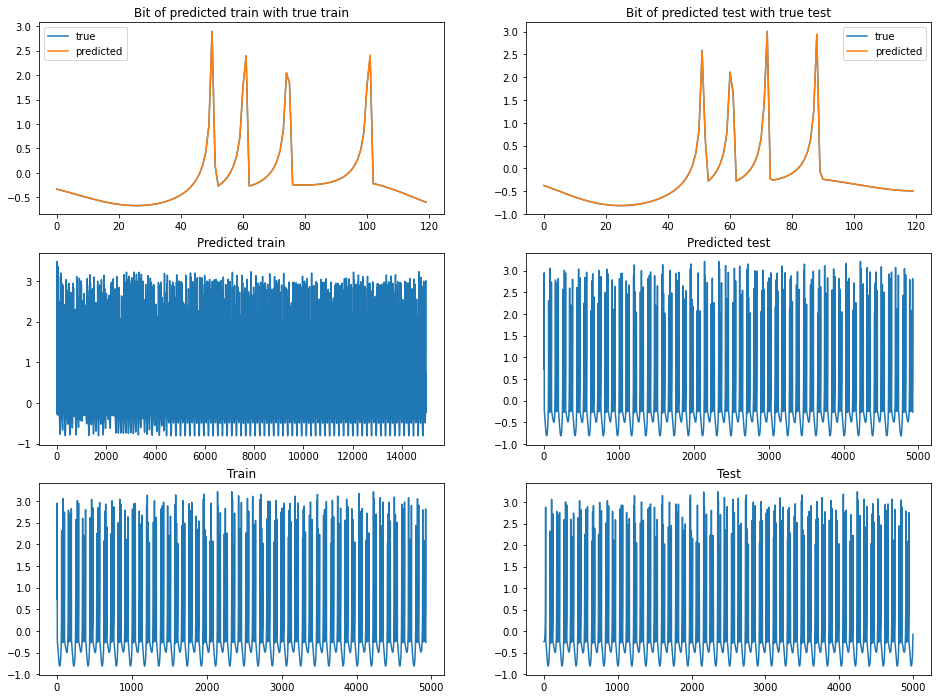

In [75]:
ShowPredict(model, traingr4, testgr4, meanx, stdx)

Train rmse: 0.004559351763449833
Test rmse: 0.004959143090171592


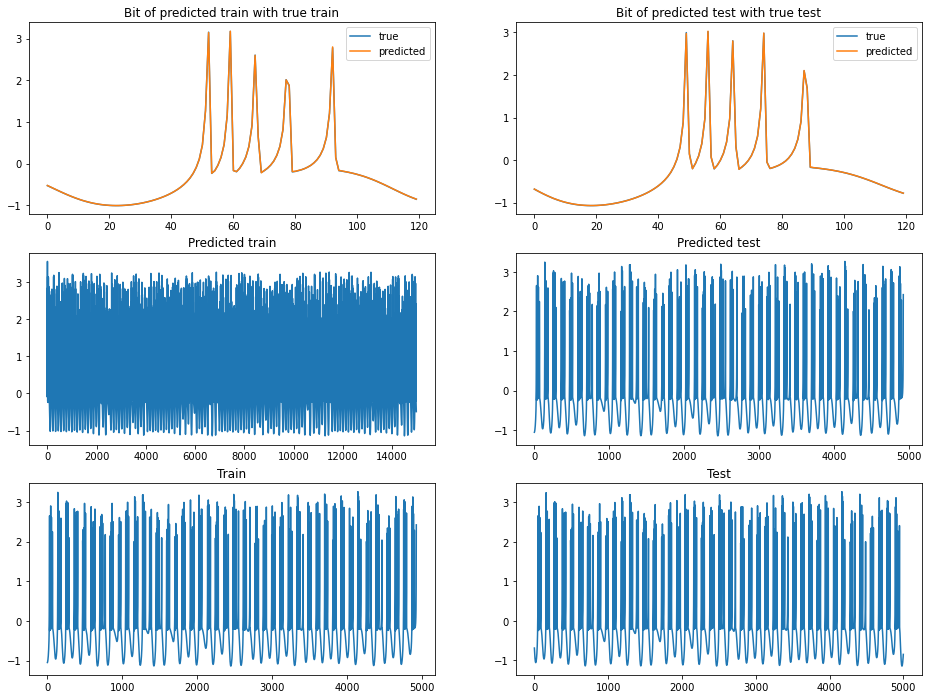

In [76]:
ShowPredict(model, traingr5, testgr5, meanx, stdx)

Train rmse: 0.0049585436437786555
Test rmse: 0.0045124225786075485


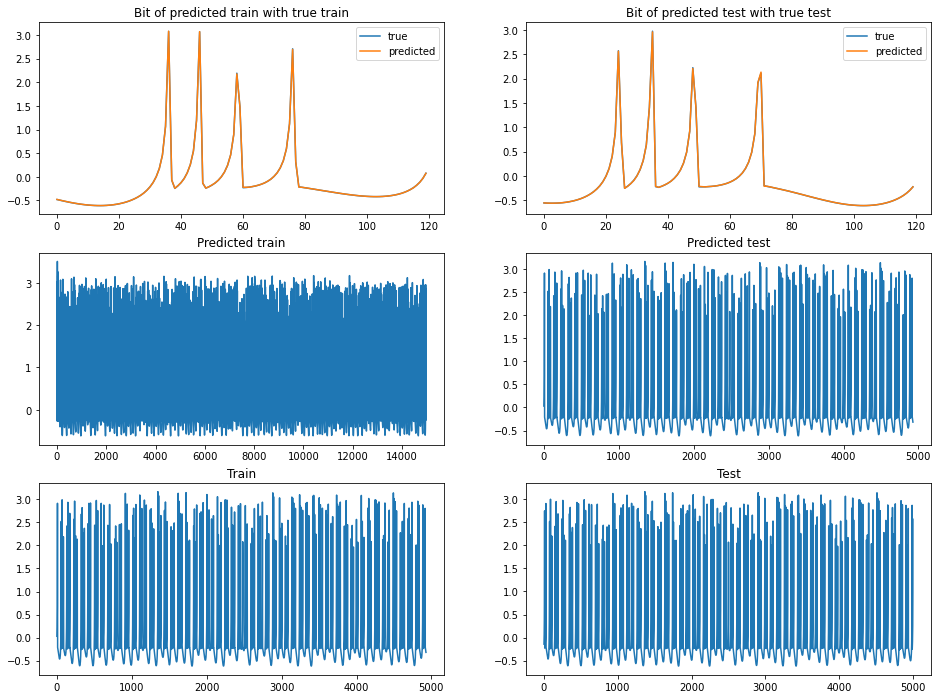

In [77]:
ShowPredict(model, traingr6, testgr6, meanx, stdx)